# Machine Learning Lab Project - Credit Card Overdue Likelihood Prediction
##  Business Understanding

## Data Understanding
The data for this task is taken from [this](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction) kaggle dataset. The kaggle page provides two `.csv` files:
- application_record.csv
- credit_record.csv

On a simple level, `application_record.csv` contains the customer data and `credit_record.csv` contains the customers credit history. The specific content is now investigated further.

For beeing able to analyse the datasets, the necessary libraries are imported first:

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In this next step the two `.csv` files are loaded into a pandas datafram. This enables an analysis with the full pandas funcionality, which makes the data understanding process way easier.

In [3]:
customer_df = pd.read_csv("Data/application_record.csv")
credit_df = pd.read_csv("Data/credit_record.csv")

### application_record.csv
First, it is important to analyse the columns of the dataset:

In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

As can be seen above, the dataset consists of 17 columns, containing numeral as well as textual data. It also seems as if there is already an unique identifier for every customer in the column `ID`. A concrete description fo these different columns can be retrieved from the datasets [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data):

|Feature name|Explanation|Remarks|
|:-----------|:----------|:------|
|ID 	     |Client number||
|CODE_GENDER |	Gender 	||
|FLAG_OWN_CAR| 	Is there a car 	||
|FLAG_OWN_REALTY| 	Is there a property|| 	
|CNT_CHILDREN| 	Number of children 	||
|AMT_INCOME_TOTAL| 	Annual income 	||
|NAME_INCOME_TYPE| 	Income category 	||
|NAME_EDUCATION_TYPE| 	Education level ||	
|NAME_FAMILY_STATUS| 	Marital status 	||
|NAME_HOUSING_TYPE| 	Way of living 	||
|DAYS_BIRTH| 	Birthday |	Count backwards from current day (0), -1 means yesterday|
|DAYS_EMPLOYED| 	Start date of employment |	Count backwards from current day(0). If positive, it means the person currently  unemployed.|
|FLAG_MOBIL| 	Is there a mobile phone 	||
|FLAG_WORK_PHONE| 	Is there a work phone 	||
|FLAG_PHONE| 	Is there a phone 	||
|FLAG_EMAIL| 	Is there an email 	||
|OCCUPATION_TYPE| 	Occupation 	||
|CNT_FAM_MEMBERS| 	Family size||

Now that the purpose of the columns is clear, the actual data can be analyzed:

In [5]:
customer_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


From these first five entries several things can be observed:
1. The ID does not start from 0 but seems to be unique.
2. For the `CODE_GENDER` the flags `F` (Female) and `M` (Male) are used.
3. For `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` the flags `Y` (Yes) and `N` (No) are used.
4. For `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS` and `NAME_HOUSING_TYPE` are textual fields, but seem to have only a few different values.
5. `OCCUPATION_TYPE` is a textual field and the values seem to be very different ("Freetext Field").
6. For `FLAG_MOBIL`, `FLAG_WORK_PHONE`, `FLAG_PHONE` and `FLAG_EMAIL` the flags 1 (Yes) and 0 (No) are used.

Before basing the data perparation on these findings, the assumptions have to be validated:

#### 1. Unique `ID`

In [6]:
customer_df['ID'].value_counts()

ID
7137299    2
7702238    2
7282535    2
7243768    2
7050948    2
          ..
5690727    1
6621262    1
6621261    1
6621260    1
6842885    1
Name: count, Length: 438510, dtype: int64

The ouptut of the value count clearly shows that not every ID is unique. As some IDs are contained twice, the real amout of customers contained in the dataset is only 438510.
#### 2. Gender

In [7]:
customer_df['CODE_GENDER'].value_counts()

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64

For the gender the assumption that only the flags `F` and `M` are used was correct.
#### 3. Flag Car / Real-Estate

In [8]:
print(customer_df['FLAG_OWN_CAR'].value_counts())
print(customer_df['FLAG_OWN_REALTY'].value_counts())

FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64
FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


Also for the flags for the possesion of car and real-estate the assumption that there are only the flags `Y` and `N` was correct.
#### 4. Text fields income, education, family and housing

In [9]:
customer_df['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64

As can be seen above, there are five different types of income. This means the column can be encoded without any problems and can be used for the modeling later.

In [10]:
customer_df['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64

The education field also consists of only five types and can therefore also be used for modelling without any problems.

In [11]:
customer_df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64

Also the family status has five different values.

In [12]:
customer_df['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: count, dtype: int64

The housing has six different values, which is still acceptable.
#### 5. Text field occupation type

In [13]:
print(customer_df['OCCUPATION_TYPE'].value_counts())
print("Amount of null values: ", customer_df['OCCUPATION_TYPE'].isnull().sum())

OCCUPATION_TYPE
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64
Amount of null values:  134203


Even though there are way less different values than expected (only 18), the column contains many null values, which may make it difficult to work with it.
#### 6. Contact method flags

In [14]:
print(customer_df['FLAG_MOBIL'].value_counts())
print(customer_df['FLAG_WORK_PHONE'].value_counts())
print(customer_df['FLAG_PHONE'].value_counts())
print(customer_df['FLAG_EMAIL'].value_counts())

FLAG_MOBIL
1    438557
Name: count, dtype: int64
FLAG_WORK_PHONE
0    348156
1     90401
Name: count, dtype: int64
FLAG_PHONE
0    312353
1    126204
Name: count, dtype: int64
FLAG_EMAIL
0    391102
1     47455
Name: count, dtype: int64


As expected, these columns only use the flags `1` and `0`. On top of that, column `FLAG_MOBIL` only contains the value `1`, which means all customers at least are registered with a mobile phone. Therefore, this column can be left out completely.
### credit_record.csv
Again, first analyze the columns:

In [15]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


As can be seen above, this table only contains three columns. According to the [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data), these columns mean the following:

|Feature name| 	Explanation |	Remarks|
|:-|:-|:-|
|ID |	Client number 	||
|MONTHS_BALANCE |	Record month |	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on|
|STATUS |	Status| 	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month|

Checking for unique `ID` values now reveals for how many customers there exists credit data:

In [16]:
len(credit_df['ID'].unique())

45985

There is only credit data for 45985 customers, that means only parts of the `customer_df` can be used.
As a last step check the values of the `STATUS` column:

In [17]:
credit_df['STATUS'].value_counts()

print(credit_df)

              ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]


The information given on the kaggle page is correct, only the stated flags are used.
### Summary
Overall, the dataset consists of two parts: the customer data and the credit data. The customer data mostly contains information about income, job, family situation and contact methods as these are important aspects for evaluating the creditworthiness. The credit data is basically a credit history overview, showing for a given custumer and month if the credit was paid back on time. This credit data can now be used for calculating an "overdue_likelyhood" for every customer which states how likely it is for this specific customer to not pay it's credit back in time. This is an important information for a credit institute. Based on all the findings in this section the two datasets can now be prepared, connected and finally used for training a machine learning model.

## Data Preparation

Get the overdue likelyhood for the customers:

STATUS    0  1  2  3  4  5   C   X
ID                                
5001711   3  0  0  0  0  0   0   1
5001712  10  0  0  0  0  0   9   0
5001713   0  0  0  0  0  0   0  22
5001714   0  0  0  0  0  0   0  15
5001715   0  0  0  0  0  0   0  60
...      .. .. .. .. .. ..  ..  ..
5150482  12  0  0  0  0  0   6   0
5150483   0  0  0  0  0  0   0  18
5150484  12  0  0  0  0  0   1   0
5150485   2  0  0  0  0  0   0   0
5150487   0  0  0  0  0  0  30   0

[45985 rows x 8 columns]
STATUS       ID  overdue_likelihood
1       5001712            0.550000
3       5001714            1.000000
5       5001717            0.782609
6       5001718            0.900000
7       5001719            0.068182
The number of entries with NaN values in overdue_likelihood: 0


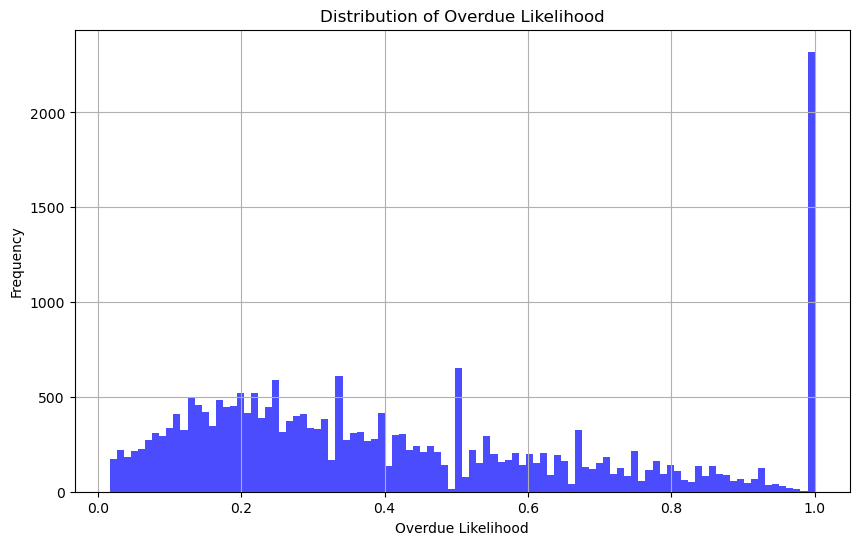

STATUS,ID,overdue_likelihood
STATUS,,
ID,1.000000,0.024984
overdue_likelihood,0.024984,1.000000


In [18]:
grouped_df = credit_df.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)

print(grouped_df)

#grouped_df['overdue_likelihood'] = 1 - (grouped_df['C'] / (grouped_df.sum(axis=1) - grouped_df['X']))
grouped_df['overdue_likelihood'] = 1 - (grouped_df['C'] / (grouped_df.sum(axis=1) - grouped_df['X']+ 1))
result_df = grouped_df.reset_index()[['ID', 'overdue_likelihood']]

# Define a probability mask to randomly exclude most of the entries with an overdue_likelihood of 1.0
probability_mask = (np.random.rand(len(result_df)) < 0.1) | (result_df['overdue_likelihood'] != 1.0)

# Apply the probability mask to the dataframe
result_df = result_df[probability_mask]

print(result_df.head())

nan_count = result_df['overdue_likelihood'].isna().sum()

print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

# Plot the distribution of overdue likelihood
plt.figure(figsize=(10, 6))
plt.hist(result_df['overdue_likelihood'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Distribution of Overdue Likelihood')
plt.xlabel('Overdue Likelihood')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

result_df.corr()


That means ca. 33110 customers are really usable.

Remove NaN entrys

In [19]:
result_df.dropna(subset=['overdue_likelihood'], inplace=True)
nan_count = result_df['overdue_likelihood'].isna().sum()

print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

The number of entries with NaN values in overdue_likelihood: 0


Merge the data:

In [20]:

merged_df = pd.merge(customer_df, result_df, on='ID', how='inner')
print(merged_df.head())


#print(len(merged_df['ID'].unique()))

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008810           F            N               Y             0   
4  5008811           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [21]:
#bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

#bins = [0, 0.2, 0.4, 0.6,  0.8, 1]
#labels = ['1', '2', '3', '4', '5']

# Define bins with 5% steps
#bins = [i/20 for i in range(21)]  # 0, 0.05, 0.1, ..., 0.95, 1

# Define corresponding labels for each bin
#labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', 
 #         '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%',
  #        '80-85%', '85-90%', '90-95%', '95-100%']

#merged_df['overdue_class'] = pd.cut(merged_df['overdue_likelihood'], bins=bins, labels=labels, include_lowest=True)
#merged_df['overdue_class'].value_counts()


#Manual resampling

# Find the number of samples in the smallest class
#min_class_size = merged_df['overdue_class'].value_counts().min()
#print(f"Minimum class size: {min_class_size}")

# Resample each class to have the same number of samples as the smallest class
#resampled_df = merged_df.groupby('overdue_class').apply(lambda x: x.sample(min_class_size, replace=True)).reset_index(drop=True)
#merged_df = resampled_df
# Check the class distribution after resampling
#print(resampled_df['overdue_class'].value_counts())

In [22]:
one_hot_cols = []
ordinal_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']


merged_df = merged_df.drop('OCCUPATION_TYPE', axis=1)
merged_df = merged_df.drop('NAME_HOUSING_TYPE', axis=1)
merged_df = merged_df.drop('NAME_INCOME_TYPE', axis=1)
merged_df = merged_df.drop('NAME_FAMILY_STATUS', axis=1)
#merged_df = merged_df.drop('overdue_likelihood', axis=1)
merged_df = merged_df.drop('ID', axis=1)

df_ord = merged_df.copy()
ordinal_encoder = OrdinalEncoder()
df_ord[ordinal_cols] = ordinal_encoder.fit_transform(df_ord[ordinal_cols])

df_enc = pd.get_dummies(df_ord, columns=one_hot_cols)


print(df_enc.head())

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0          1.0           1.0              1.0             0          427500.0   
1          1.0           1.0              1.0             0          427500.0   
2          1.0           1.0              1.0             0          112500.0   
3          0.0           0.0              1.0             0          270000.0   
4          0.0           0.0              1.0             0          270000.0   

   NAME_EDUCATION_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
0                  1.0      -12005          -4542           1   
1                  1.0      -12005          -4542           1   
2                  4.0      -21474          -1134           1   
3                  4.0      -19110          -3051           1   
4                  4.0      -19110          -3051           1   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                1           0           0              2.0

In [28]:

# Assuming X_enc is already defined and includes 'overdue_likelihood'
# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_enc)
df_scaled = pd.DataFrame(X_scaled, columns=df_enc.columns)

# Define the target count for each group
target_count_per_group = 8000

# We'll create a new DataFrame to hold the augmented data
augmented_df = pd.DataFrame()

# Define a function to apply noise
def apply_noise(series, noise_level=0.015):
    # Apply slight noise to a pandas Series
    return series.apply(lambda x: x + np.random.uniform(-noise_level, noise_level))

# Assuming 'overdue_likelihood' is the last column in df_scaled
overdue_likelihood_scaled = df_scaled.iloc[:, -1]

# Group the data based on the scaled 'overdue_likelihood'
for i in range(100):
    # Calculate the group range
    lower_bound = i / 100
    upper_bound = (i + 1) / 100
    
    # Filter the DataFrame for the current group
    group_df = df_scaled[(overdue_likelihood_scaled >= lower_bound) & (overdue_likelihood_scaled < upper_bound)]
    
    # Calculate the number of duplicates needed
    duplicates_needed = target_count_per_group - len(group_df)
    
    if duplicates_needed > 0:
        # Duplicate rows and add them to a temporary DataFrame
        duplicated_rows = pd.concat([group_df] * (duplicates_needed // len(group_df) + 1), ignore_index=True)
        
        # Keep only as many as needed to reach the target count
        duplicated_rows = duplicated_rows.iloc[:duplicates_needed, :]
        
        # Apply noise to all columns except 'ID'
        duplicated_rows.iloc[:, :-1] = duplicated_rows.iloc[:, :-1].apply(lambda col: apply_noise(col, noise_level=0.005))
        
        # Append the duplicated rows to the group DataFrame
        group_df = pd.concat([group_df, duplicated_rows], ignore_index=True)
    
    # Append the group to the augmented DataFrame
    augmented_df = pd.concat([augmented_df, group_df], ignore_index=True)

# Shuffle the augmented DataFrame
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

# Print the first few rows of the augmented DataFrame
#print(augmented_df.head())

# Calculate and print the correlation matrix
#corr_mat = augmented_df.corr(method='pearson')
#print(corr_mat)


Y = augmented_df['overdue_likelihood']
# Assuming df_enc is your original dataframe and is already defined
X_enc = augmented_df.drop([
    'overdue_likelihood'#, 'FLAG_WORK_PHONE', 'FLAG_PHONE', 
    #'FLAG_EMAIL', 'FLAG_MOBIL', 'FLAG_OWN_REALTY', 
    #'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'CODE_GENDER', 'DAYS_BIRTH',
    #'CNT_FAM_MEMBERS', 'DAYS_EMPLOYED'
    
], axis=1)

# Apply MinMaxScaler
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X_enc)
#df_scaled = pd.DataFrame(X_scaled, columns=X_enc.columns)
#df_scaled = pd.DataFrame(X_enc, columns=X_enc.columns)



# Print the preprocessed data
print(augmented_df.head())
#corr_mat = 
#df_scaled.corr(method='pearson')
#print(corr_mat)

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0     0.000192      0.002269         1.002511     -0.002654          0.053438   
1     0.002613      0.996580         1.000116     -0.001483          0.461327   
2     0.997019      0.996602        -0.001179      0.284654          0.084201   
3    -0.002379     -0.001722         0.995530     -0.000138          0.073855   
4    -0.000587     -0.003018        -0.002435      0.001375          0.030718   

   NAME_EDUCATION_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
0             0.250303    0.709505       0.042525   -0.000419   
1             0.245720    0.196593       0.995483   -0.004179   
2             0.997204    0.725237       0.035489   -0.004984   
3             1.003594    0.140276       0.995070   -0.000379   
4             0.995828    0.419272       0.044613   -0.003224   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0         0.004706   -0.004810   -0.001679         0.120072

# TODO:
- overdue-likelyhood zu labels
- encoden
    - Eig geht fast alles ordinal encoded
    - OCCUPATION_TYPE fliegt ganz raus
- scalen
- random forest




## Modeling

In [29]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df, Y, test_size=0.01, random_state=0)
X_train = X_train.drop([
    'overdue_likelihood'], axis=1)
X_test = X_test.drop([
    'overdue_likelihood'], axis=1)

In [30]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.is_gpu_available():
    print("TensorFlow can access the GPU")
else:
    print("TensorFlow cannot access the GPU")


model = Sequential([
    Dense(512, activation='relu', input_shape=(13,)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile( optimizer='adam', loss='binary_crossentropy')

model.fit(X_train, y_train, epochs=10, batch_size=64)

model.evaluate(X_test, y_test)

Num GPUs Available:  0
TensorFlow cannot access the GPU
Epoch 1/10
12375/12375 [==============================] - 160s 13ms/step - loss: 0.6649
Epoch 2/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6305
Epoch 3/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6166
Epoch 4/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6098
Epoch 5/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6056
Epoch 6/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6027
Epoch 7/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.6005
Epoch 8/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.5989
Epoch 9/10
12375/12375 [==============================] - 159s 13ms/step - loss: 0.5974
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 0.5994


0.5993788242340088

250/250 [==============================] - 1s 3ms/step


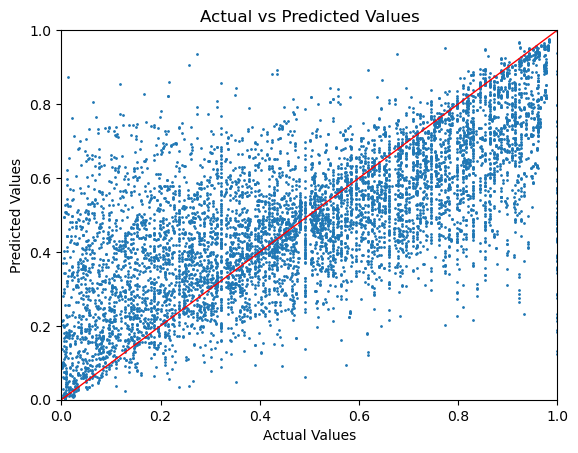

In [32]:
y_pred = model.predict(X_test)


plt.scatter(y_test, y_pred, s=1)  # Making the points smaller with size=10
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Adding y=x line (identity line)
plt.plot([0, 1], [0, 1], color='red', linestyle='-', linewidth=1)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()